In [1]:
import pickle as pkl
import gzip
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import img_to_array
from keras.preprocessing import image
import numpy as np
import cv2
import math
import pandas as pd
from PIL import Image
from keras.models import Model
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from skimage.transform import resize
from sklearn.preprocessing import MinMaxScaler, RobustScaler, QuantileTransformer, PowerTransformer
from sklearn.model_selection import train_test_split
from matplotlib.patches import Rectangle
import matplotlib.gridspec as gridspec
#import torch
#import torch.nn as nn
#from torch.utils.data import DataLoader
#from torchvision import datasets, transforms
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dropout, Conv2DTranspose, concatenate, Lambda
from tensorflow.keras.backend import int_shape
from sklearn.model_selection import KFold
from tensorflow.keras.layers import Dense
from keras.layers import Flatten, Reshape
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.utils import plot_model
from scipy.ndimage import gaussian_filter
from scipy.ndimage import median_filter
from scipy.ndimage import generic_filter
from scipy.interpolate import NearestNDInterpolator
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_absolute_percentage_error
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Nadam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate, Activation, BatchNormalization, SeparableConv2D, GlobalAveragePooling2D, Multiply, Add
from tensorflow.keras.regularizers import l2

In [2]:
with gzip.open('file_d.pkl.gz', 'rb') as f:
    data = pkl.load(f)

In [3]:
key_list = []
for key in data.keys():
    key_list.append(key)

In [4]:
abc_vals = [(60, 60, 20),
 (80, 80, 20),
 (70, 70, 20),
 (30, 70, 20),
 (50, 70, 20),
 (85, 70, 20),
 (90, 70, 20),
 (100, 70, 20),
 (70, 30, 20),
 (70, 50, 20),
 (70, 85, 20),
 (70, 100, 20),
 (70, 120, 20),
 (70, 70, 10),
 (70, 70, 5),
 (70, 70, 15),
 (70, 70, 25),
 (90, 50, 25),
 (90, 30, 25),
 (10, 10, 25),
 (30, 10, 25),
 (50, 10, 25),
 (10, 50, 25),
 (10, 30, 25),
 (25, 60, 25),
 (25, 90, 25),
 (90, 15, 25),
 (40, 15, 25),
 (50, 90, 25),
 (90, 50, 25),
 (100, 100, 25),
 (100, 100, 15),
 (3, 30, 15),
 (30, 30, 15),
 (90, 50, 15)]

In [5]:
keys = key_list + abc_vals

In [6]:
pix = 224
shapes = []
for tupl in abc_vals:
    a = tupl[0]
    b = tupl[1]
    c = tupl[2]
    x = np.linspace(0, 224, pix)
    y = np.linspace(0, 224, pix)
    z = np.linspace(-c, 0, pix // 2)
    x,y,z = np.meshgrid(x, y , z)
    center_x, center_y, center_z = 112, 112, 0
    ellipsoid = ((x-center_x)**2/ a**2) + ((y-center_y)**2 / b**2) + ((z-center_z)**2/c**2)
    mask =(ellipsoid>=1)
    max_z = np.full((pix, pix), -np.inf)
    for i in range(pix // 2):
        max_z = np.maximum(max_z, np.where(mask[:,:,i], z[:,:,i], -np.inf))
    max_z[max_z == -np.inf] = 0
    shapes.append(max_z)

In [7]:
synthetic = np.stack(shapes, axis = 0)
synthetic.shape

(35, 224, 224)

In [8]:
synthetic = synthetic / 25

In [9]:
def get_Z(data):
    z_list = []
    for file, item in data.items():
        for t in item:
            z_list.append(t[2])
    Z = np.array(z_list)
    Z = Z.reshape((343, 1000, 1000))
    Z = Z.astype(np.float64)
    print("Z done")
    return Z

In [10]:
def translate_depths(Z):
    max_vals = Z.max(axis = (1,2), keepdims = True)
    ims_norm = Z - max_vals
    print("trans done")
    return ims_norm

In [11]:
def scale_minimum(Z):
    min = Z.min(axis = (1,2), keepdims = True)
    ims_norm = Z / np.abs(min)
    print("scale done")
    return ims_norm

In [12]:
def translate(images):
    images_translated = np.zeros(images.shape)
    for i in range(images.shape[0]):
        min = np.min(images[i])
        images_translated[i] = images[i] - min
    return images_translated

In [13]:
def resize_scale(Z):
    Z = Z.reshape((343, 1000, 1000))
    resized_arrays = np.empty((343, 224, 224))
    for i in range(Z.shape[0]):
        resized_arrays[i] = cv2.resize(Z[i], (224, 224))
    return resized_arrays

In [14]:
def prepare(resized_arrays):
    resized_images = np.repeat(resized_arrays[:,:,:, np.newaxis], 3, axis = -1)
    ready = preprocess_input(resized_images * 255)
    return ready

In [15]:
def compute_outliers(images):
    mean = np.mean(images, axis = (1, 2), keepdims = True)
    std = np.std(images, axis = (1, 2), keepdims = True)

    Z = (images - mean) / std

    return Z > 2.5

In [16]:
def interpolate_outliers(images, outliers):
    interpolated_images = np.empty_like(images)
    for i, (image, outlier) in enumerate(zip(images, outliers)):
        y,x = np.nonzero(~outlier)
        non_outliers = image[~outlier]
        y_out, x_out = np.nonzero(outlier)
        if(y.size == 0 or x.size == 0):
            interpolated_images[i] = image
            continue
    
        interpolator = NearestNDInterpolator(list(zip(y, x)), non_outliers)
    
        interpolated_values = interpolator(y_out,x_out)
        new_img = image.copy()
        new_img[outlier] = interpolated_values
        interpolated_images[i] = new_img
    return interpolated_images

In [17]:
Z = get_Z(data)

Z done


In [18]:
translate_Z = translate_depths(Z)
scale_Z = scale_minimum(translate_Z)

trans done
scale done


In [19]:
resized = resize_scale(scale_Z)

In [20]:
outliers = compute_outliers(resized)

In [21]:
processed2 = interpolate_outliers(resized, outliers)

In [22]:
translated = translate(processed2)

In [23]:
syn_z = translate(synthetic)

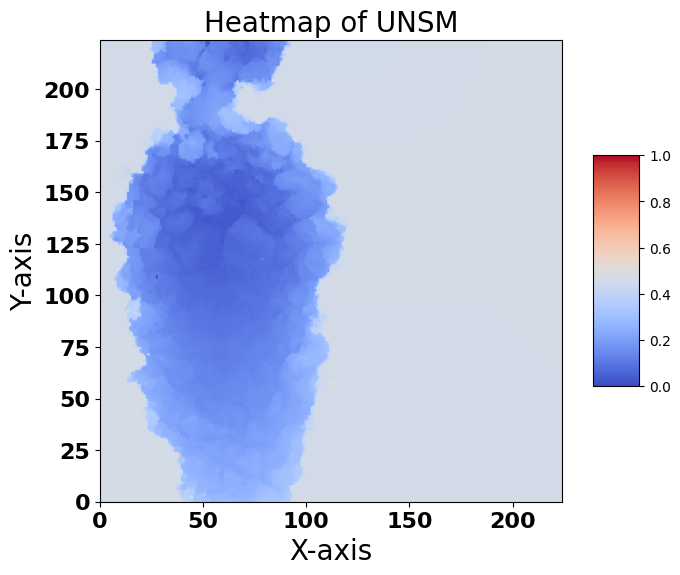

In [25]:
fig, ax = plt.subplots(figsize = (8, 6))
heatmap = ax.imshow(translated[14], extent=[0, 224, 0, 224], cmap='coolwarm', vmin = 0, vmax = 1)
fig.colorbar(heatmap, ax = ax, shrink = 0.5, aspect = 5)
plt.title('Heatmap of UNSM', fontsize = 20)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)
plt.xticks(fontsize=16, fontweight='bold')
plt.yticks(fontsize=16, fontweight='bold')
ax.set_xlabel('X-axis', fontsize = 20)
ax.set_ylabel('Y-axis', fontsize = 20)
plt.show()

In [26]:
def data_pipeline_non_scaled(Z):
    Z = Z.reshape((343, 1000, 1000))
    resized_arrays = np.empty((343, 224, 224))
    for i in range(Z.shape[0]):
        resized_arrays[i] = cv2.resize(Z[i], (224, 224))
    resized_images = np.repeat(resized_arrays[:,:,:, np.newaxis], 3, axis = -1)
    ready = preprocess_input(resized_images * 255)
    return ready

In [27]:
def data_pipeline_scaler(Z):
    scaler = QuantileTransformer(output_distribution = 'uniform', n_quantiles = 100)
    Z = Z.reshape((343, 1000, 1000))
    Z_n = Z.reshape(-1, 1)
    normalized = scaler.fit_transform(Z_n)
    normalized.reshape(-1)
    Z_norm = normalized.reshape((343, 1000, 1000))
    resized_arrays = np.empty((343, 224, 224))

    for i in range(Z_norm.shape[0]):
        resized_arrays[i] = cv2.resize(Z_norm[i], (224, 224))
    resized_images = np.repeat(resized_arrays[:,:,:, np.newaxis], 3, axis = -1)
    ready = preprocess_input(resized_images * 255)
    return ready

In [28]:
ready_v2 = prepare(translated)
#ready_ref = prepare(ref_translated)
ready_v2.shape

(343, 224, 224, 3)

In [29]:
syn_ready = prepare(syn_z)

In [30]:
ready = prepare(resized)

In [31]:
def shift_left(resized, shift_val):
    shifted_left = np.zeros_like(resized)
    
    for i in range(len(resized)):
        img = resized[i]
        shifted_array = np.zeros_like(img)  # Create an empty array of the same shape
        shifted_array[:, :-shift_val] = img[:, shift_val:]
        
        for j in range(shift_val):
            shifted_array[:, -j - 1] = shifted_array[:, -shift_val - 1]
        shifted_left[i] = shifted_array
    return shifted_left

In [32]:
def shift_right(resized, shift_val):
    shifted_right = np.zeros_like(resized)
    
    for i in range(len(resized)):
        img = resized[i]
        shifted_array = np.zeros_like(img)  # Create an empty array of the same shape
        shifted_array[:, shift_val:] = img[:, :-shift_val]
        
        for j in range(shift_val):
            shifted_array[:, j] = shifted_array[:, shift_val]
        shifted_right[i] = shifted_array
    return shifted_right

In [33]:
def shift_diagonal_rightdown(resized, shift_val):
    shifted_diagonal = np.zeros_like(resized)
    
    for i in range(len(resized)):
        img = resized[i]
        shifted_array = np.zeros_like(img)  # Create an empty array of the same shape
        
        # Shift right and down
        shifted_array[shift_val:, shift_val:] = img[:-shift_val, :-shift_val]
        
        # Fill the top rows with the first shifted row
        for j in range(shift_val):
            shifted_array[j, :] = shifted_array[shift_val, :]
        
        # Fill the left columns with the first shifted column
        for k in range(shift_val):
            shifted_array[:, k] = shifted_array[:, shift_val]
        
        shifted_diagonal[i] = shifted_array
    return shifted_diagonal

In [34]:
def shift_diagonal_left_up(resized, shift_val):
    shifted_diagonal = np.zeros_like(resized)
    
    for i in range(len(resized)):
        img = resized[i]
        shifted_array = np.zeros_like(img)  # Create an empty array of the same shape
        
        # Shift left and up
        shifted_array[:-shift_val, :-shift_val] = img[shift_val:, shift_val:]
        
        # Fill the bottom rows with the last shifted row
        for j in range(shift_val):
            shifted_array[-(j+1), :] = shifted_array[-(shift_val+1), :]
        
        # Fill the right columns with the last shifted column
        for k in range(shift_val):
            shifted_array[:, -(k+1)] = shifted_array[:, -(shift_val+1)]
        
        shifted_diagonal[i] = shifted_array
    return shifted_diagonal

In [35]:
def shift_diagonal_left_down(resized, shift_val):
    shifted_diagonal = np.zeros_like(resized)
    
    for i in range(len(resized)):
        img = resized[i]
        shifted_array = np.zeros_like(img)  # Create an empty array of the same shape
        
        # Shift left and down
        shifted_array[shift_val:, :-shift_val] = img[:-shift_val, shift_val:]
        
        # Fill the top rows with the first shifted row
        for j in range(shift_val):
            shifted_array[j, :] = shifted_array[shift_val, :]
        
        # Fill the right columns with the last shifted column
        for k in range(shift_val):
            shifted_array[:, -(k+1)] = shifted_array[:, -(shift_val+1)]
        
        shifted_diagonal[i] = shifted_array
    return shifted_diagonal

In [36]:
def shift_diagonal_right_up(resized, shift_val):
    shifted_diagonal = np.zeros_like(resized)
    
    for i in range(len(resized)):
        img = resized[i]
        shifted_array = np.zeros_like(img)  # Create an empty array of the same shape
        
        # Shift right and up
        shifted_array[:-shift_val, shift_val:] = img[shift_val:, :-shift_val]
        
        # Fill the bottom rows with the last shifted row
        for j in range(shift_val):
            shifted_array[-(j+1), :] = shifted_array[-(shift_val+1), :]
        
        # Fill the left columns with the first shifted column
        for k in range(shift_val):
            shifted_array[:, k] = shifted_array[:, shift_val]
        
        shifted_diagonal[i] = shifted_array
    return shifted_diagonal

In [37]:
diagonal_right_down_ref = shift_diagonal_rightdown(translated, 25)
diagonal_left_up_ref = shift_diagonal_left_up(translated, 25)
diagonal_left_down_ref = shift_diagonal_left_down(translated, 25)
diagonal_right_up_ref = shift_diagonal_right_up(translated, 25)

In [38]:
left = shift_left(translated, 25)
left_less = shift_left(translated, 10)

In [39]:
right = shift_right(translated, 25)
right_less = shift_right(translated, 10)

In [40]:
augment_shift = np.concatenate((left, right, left_less, right_less, diagonal_right_down_ref,  diagonal_right_up_ref,  diagonal_left_down_ref,  diagonal_left_up_ref))

In [41]:
augment_shift.shape

(2744, 224, 224)

In [42]:
rot_90 = np.empty((343, 224, 224))
rot_180 = np.empty((343, 224, 224))
rot_270 = np.empty((343, 224, 224))
for i in range(len(translated)):
    rot_90[i] = cv2.rotate(translated[i], cv2.ROTATE_90_CLOCKWISE)
    rot_180[i] = cv2.flip(translated[i], 0)
    rot_270[i] = cv2.rotate(translated[i], cv2.ROTATE_90_COUNTERCLOCKWISE)

In [43]:
augment_rotate = np.concatenate((rot_90, rot_180, rot_270))

In [44]:
augment_rotate.shape

(1029, 224, 224)

In [45]:
augment = np.concatenate((augment_shift, augment_rotate))
augment.shape

(3773, 224, 224)

In [46]:
x_train, x_val = train_test_split(augment, test_size = 0.2)

In [47]:
model = load_model('anetbest.h5')

In [48]:
##grayscale model
def AttentionBlock(x, g, inter_channel):
    theta_x = Conv2D(inter_channel, (2, 2), strides=(2, 2), padding='same')(x)
    phi_g = Conv2D(inter_channel, (1, 1), padding='same')(g)
    concat_xg = Add()([theta_x, phi_g])
    act_xg = Activation('relu')(concat_xg)
    psi = Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = Activation('sigmoid')(psi)
    upsample_psi = Conv2DTranspose(x.shape[-1], (2, 2), strides=(2, 2), padding='same')(sigmoid_xg)
    y = Multiply()([upsample_psi, x])
    return y

def Conv2dBlock(inputTensor, numFilters, kernelSize=3, doBatchNorm=True):
    x = Conv2D(filters=numFilters, kernel_size=(kernelSize, kernelSize), kernel_initializer='he_normal', padding='same', kernel_regularizer=l2(0.001))(inputTensor)
    if doBatchNorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = SeparableConv2D(filters=numFilters, kernel_size=(kernelSize, kernelSize), kernel_initializer='he_normal', padding='same', kernel_regularizer=l2(0.001))(x)
    if doBatchNorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters=numFilters, kernel_size=(kernelSize, kernelSize), dilation_rate=2, kernel_initializer='he_normal', padding='same', kernel_regularizer=l2(0.001))(x)
    if doBatchNorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

def AttentionUNet(inputImage, numFilters=16, dropouts=0.1, doBatchNorm=True):
    # Encoder path
    c1 = Conv2dBlock(inputImage, numFilters * 1, kernelSize=3, doBatchNorm=doBatchNorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropouts)(p1)
    
    c2 = Conv2dBlock(p1, numFilters * 2, kernelSize=3, doBatchNorm=doBatchNorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropouts)(p2)
    
    c3 = Conv2dBlock(p2, numFilters * 4, kernelSize=3, doBatchNorm=doBatchNorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropouts)(p3)
    
    c4 = Conv2dBlock(p3, numFilters * 8, kernelSize=3, doBatchNorm=doBatchNorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropouts)(p4)
    
    c5 = Conv2dBlock(p4, numFilters * 16, kernelSize=3, doBatchNorm=doBatchNorm)
    
    # Decoder path with attention
    g1 = Conv2D(numFilters * 8, (1, 1), padding='same')(c5)
    a1 = AttentionBlock(c4, g1, numFilters * 8)
    u6 = Conv2DTranspose(numFilters * 8, (3, 3), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, a1])
    u6 = Dropout(dropouts / 2)(u6)
    c6 = Conv2dBlock(u6, numFilters * 8, kernelSize=3, doBatchNorm=doBatchNorm)
    
    g2 = Conv2D(numFilters * 4, (1, 1), padding='same')(c6)
    a2 = AttentionBlock(c3, g2, numFilters * 4)
    u7 = Conv2DTranspose(numFilters * 4, (3, 3), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, a2])
    u7 = Dropout(dropouts / 2)(u7)
    c7 = Conv2dBlock(u7, numFilters * 4, kernelSize=3, doBatchNorm=doBatchNorm)
    
    g3 = Conv2D(numFilters * 2, (1, 1), padding='same')(c7)
    a3 = AttentionBlock(c2, g3, numFilters * 2)
    u8 = Conv2DTranspose(numFilters * 2, (3, 3), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, a3])
    u8 = Dropout(dropouts / 2)(u8)
    c8 = Conv2dBlock(u8, numFilters * 2, kernelSize=3, doBatchNorm=doBatchNorm)
    
    g4 = Conv2D(numFilters, (1, 1), padding='same')(c8)
    a4 = AttentionBlock(c1, g4, numFilters)
    u9 = Conv2DTranspose(numFilters * 1, (3, 3), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, a4])
    u9 = Dropout(dropouts / 2)(u9)
    c9 = Conv2dBlock(u9, numFilters * 1, kernelSize=3, doBatchNorm=doBatchNorm)
    
    output = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    
    gap = GlobalAveragePooling2D()(c5)
    dim_final = Dense(2, activation='linear')(gap)
    
    model = Model(inputs=[inputImage], outputs=[output, dim_final])
    return model

# Input for grayscale images, with shape (224, 224, 1)
inputImage = Input((224, 224, 1))
model = AttentionUNet(inputImage)


In [49]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 224, 224, 16)         160       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 224, 224, 16)         64        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 224, 224, 16)         0         ['batch_normalization[0][0

In [49]:
# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss={'conv2d_34': 'mean_squared_error',  # Assuming 'conv2d_last' is the name of your main output layer
                    'dense': None},  # No loss calculation for the flattened features
              loss_weights={'conv2d_34': 1.0,  # Only the main output contributes to the loss
                            'dense': 0.0},  # No weight to the flattened features' loss
              metrics={'conv2d_34': ['accuracy']})

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train model
history = model.fit(x_train, x_train, validation_data=(x_val, x_val), epochs= 10, batch_size=32, callbacks=[reduce_lr, early_stopping])

Epoch 1/10


95/95 [==============================] - 172s 1s/step - loss: 0.8902 - conv2d_34_loss: 0.0145 - conv2d_34_accuracy: 2.7590e-05 - val_loss: 0.2375 - val_conv2d_34_loss: 0.0708 - val_conv2d_34_accuracy: 3.1228e-05 - lr: 0.0010
Epoch 2/10
95/95 [==============================] - 131s 1s/step - loss: 0.0886 - conv2d_34_loss: 0.0026 - conv2d_34_accuracy: 3.0073e-05 - val_loss: 0.1223 - val_conv2d_34_loss: 0.0712 - val_conv2d_34_accuracy: 3.2257e-05 - lr: 0.0010
Epoch 3/10
95/95 [==============================] - 131s 1s/step - loss: 0.0357 - conv2d_34_loss: 0.0021 - conv2d_34_accuracy: 3.1222e-05 - val_loss: 0.0874 - val_conv2d_34_loss: 0.0632 - val_conv2d_34_accuracy: 3.2653e-05 - lr: 0.0010
Epoch 4/10
95/95 [==============================] - 132s 1s/step - loss: 0.0228 - conv2d_34_loss: 0.0021 - conv2d_34_accuracy: 3.1823e-05 - val_loss: 0.0633 - val_conv2d_34_loss: 0.0445 - val_conv2d_34_accuracy: 3.2864e-05 - lr: 0.0010
Epoch 5/10
95/95 [==============================] - 13

In [78]:
kf = KFold(n_splits = 5, shuffle = True, random_state = 42)

In [85]:
fold = 1
all_scores = []
int_conv = 279
int_dense = 7

for train_index, test_index in kf.split(augment):
    print(f"Training fold {fold}...")
    X_train, X_val = augment[train_index], augment[test_index]

    inputs = Input((224, 224, 1))
    model = AttentionUNet(inputs)

    model.compile(optimizer='Adam',
                 loss={f'conv2d_{int_conv}': 'mean_squared_error', 
                       f'dense_{int_dense}': 'mean_squared_error'},
                 loss_weights={f'conv2d_{int_conv}': 1.0, 
                               f'dense_{int_dense}': 0.0},  
                 metrics={f'conv2d_{int_conv}': ['accuracy']})

    y_train = [X_train, np.zeros((X_train.shape[0], 2))]
    y_val = [X_val, np.zeros((X_val.shape[0], 2))]

    trained = model.fit(X_train, [X_train, y_train[1]], batch_size=32, epochs=10, verbose=1, validation_data=(X_val, [X_val, y_val[1]]))
    scores = model.evaluate(X_val, [X_val, y_val[1]], verbose=0)
    print(f"Fold {fold} scores: {scores}")
    all_scores.append(scores)

    int_conv += 35
    int_dense += 1
    fold += 1

mean_scores = np.mean(all_scores, axis=0)
print(f'Mean scores across all folds {mean_scores}')

Training fold 1...
Epoch 1/10
95/95 [==============================] - 166s 1s/step - loss: 0.8929 - conv2d_279_loss: 0.0111 - dense_7_loss: 0.3795 - conv2d_279_accuracy: 3.1896e-05 - val_loss: 0.2381 - val_conv2d_279_loss: 0.0695 - val_dense_7_loss: 0.0355 - val_conv2d_279_accuracy: 4.1707e-06
Epoch 2/10
95/95 [==============================] - 130s 1s/step - loss: 0.0956 - conv2d_279_loss: 0.0021 - dense_7_loss: 0.3295 - conv2d_279_accuracy: 3.1711e-05 - val_loss: 0.1133 - val_conv2d_279_loss: 0.0638 - val_dense_7_loss: 0.0277 - val_conv2d_279_accuracy: 4.1707e-06
Epoch 3/10
95/95 [==============================] - 130s 1s/step - loss: 0.0432 - conv2d_279_loss: 0.0022 - dense_7_loss: 0.3605 - conv2d_279_accuracy: 3.1863e-05 - val_loss: 0.4550 - val_conv2d_279_loss: 0.3889 - val_dense_7_loss: 80.5424 - val_conv2d_279_accuracy: 3.2284e-05
Epoch 4/10
95/95 [==============================] - 131s 1s/step - loss: 0.0358 - conv2d_279_loss: 0.0019 - dense_7_loss: 0.5556 - conv2d_279_accurac

In [ ]:
model.save('anetbest.h5')

In [50]:
encoder = Model(inputs = model.input, outputs = model.get_layer('dense').output)

In [51]:
decoder = Model(inputs = model.input, outputs = model.get_layer('conv2d_34').output)

In [52]:
reconstructed = decoder.predict(translated)

11/11 [==============================] - 10s 440ms/step


In [ ]:
encoded_data = encoder.predict(translated)

In [ ]:
encoded_syn = encoder.predict(syn_z)

In [40]:
encoded_syn.shape

(35, 2)

In [54]:
encoded_data.shape

(75, 2)

In [57]:
reconstructed.shape

(343, 224, 224, 1)

Text(0, 0.5, 'loss')

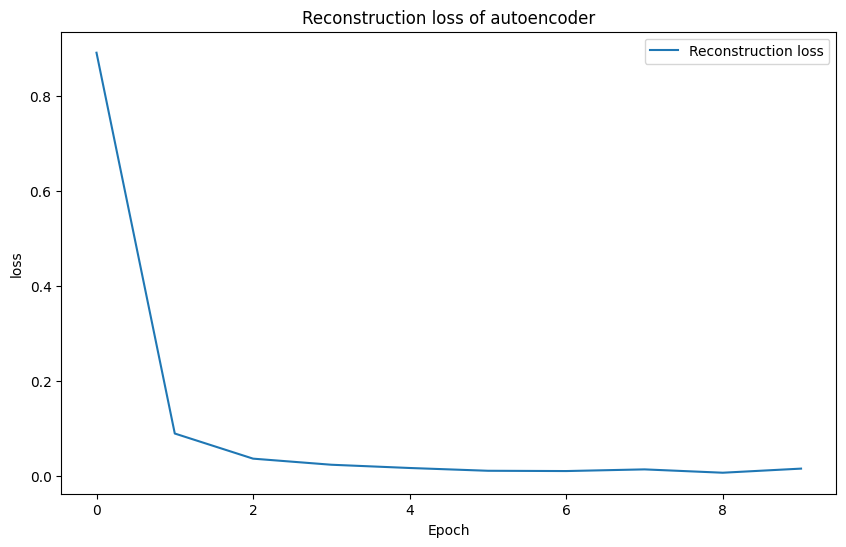

In [130]:
loss_values = history.history['loss']
plt.figure(figsize = (10,6))
plt.plot(loss_values, label = 'Reconstruction loss')
plt.title("Reconstruction loss of autoencoder")
plt.xlabel("Epoch")
plt.ylabel("loss")

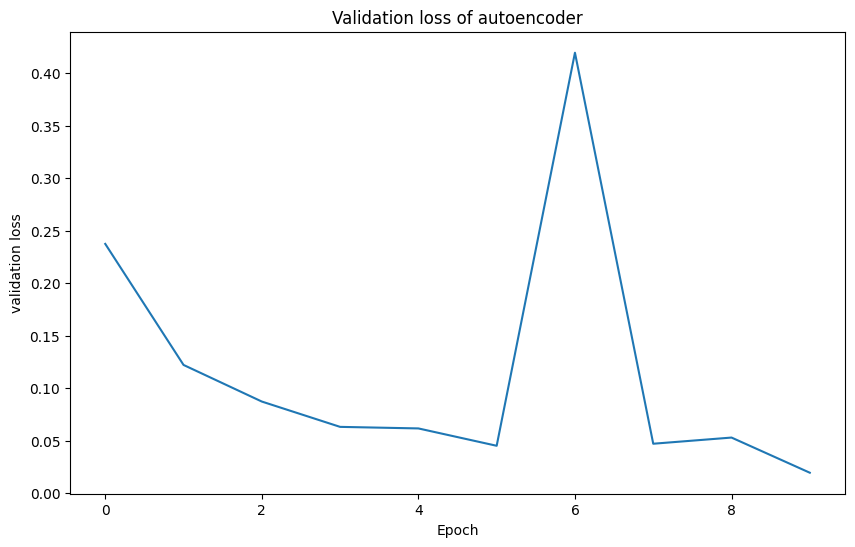

In [132]:
validation_loss = history.history['val_loss']
plt.figure(figsize = (10,6))
plt.plot(validation_loss, label = 'Validation Loss')
plt.title("Validation loss of autoencoder")
plt.xlabel("Epoch")
plt.ylabel("validation loss")
plt.show()

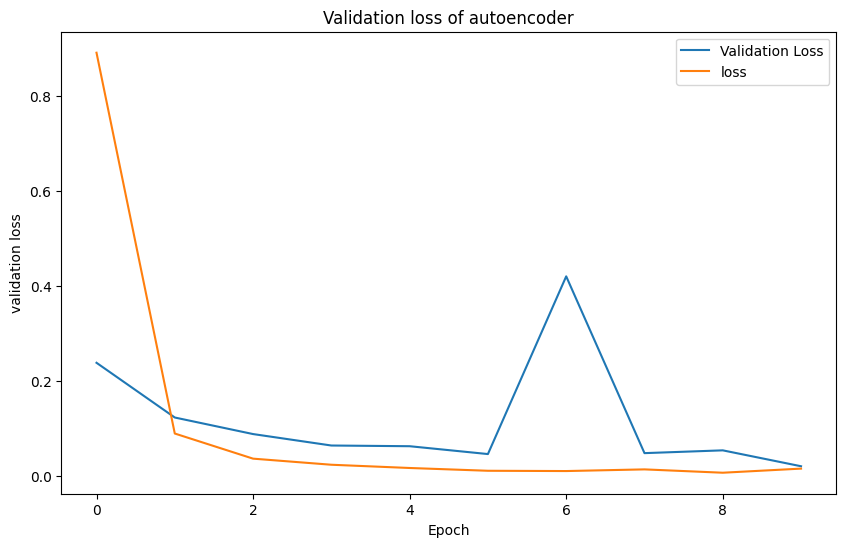

In [131]:
validation_loss = history.history['val_loss']
plt.figure(figsize = (10,6))
plt.plot(validation_loss, label = 'Validation Loss')
plt.plot(loss_values, label = 'loss')
plt.legend()
plt.title("Validation loss of autoencoder")
plt.xlabel("Epoch")
plt.ylabel("validation loss")
plt.show()

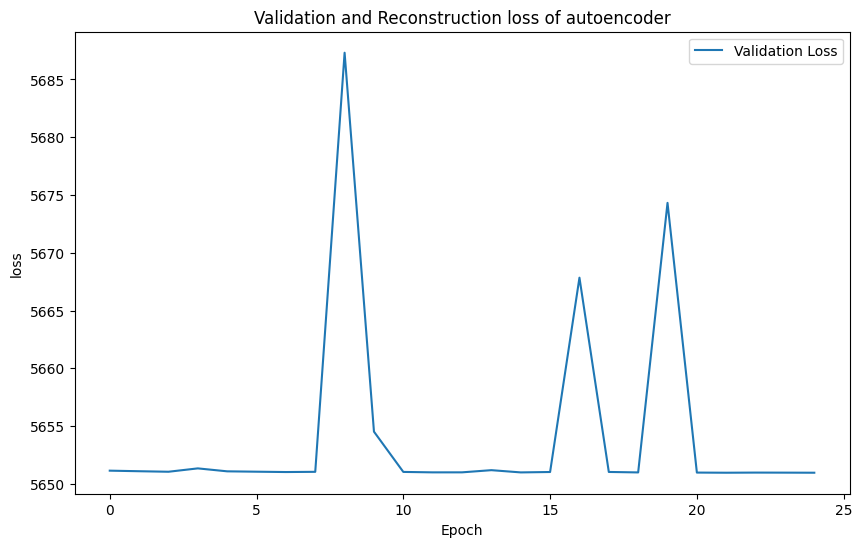

In [113]:
loss_values = history.history['conv2d_104_loss']

plt.figure(figsize = (10,6))
plt.plot(loss_values, label = 'Reconstruction loss')
plt.plot(validation_loss, label = 'Validation Loss')
plt.title("Validation and Reconstruction loss of autoencoder")
plt.xlabel("Epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

In [33]:
encoded = np.concatenate((encoded_data, encoded_syn))

In [63]:
encoded.shape

(378, 2)

In [61]:
k = 3
kmeans = KMeans(n_clusters = k).fit(encoded)

C:\Users\rahuja7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [62]:
cluster_labels = kmeans.labels_

In [63]:
centroids = kmeans.cluster_centers_
centroids

array([[-0.10085571,  0.04379188],
       [-0.0860318 ,  0.07560409],
       [-0.08302812,  0.10712397]], dtype=float32)

In [64]:
closest_points_indices = np.zeros(len(centroids), dtype=int)
for i, centroid in enumerate(centroids):
    distances = np.linalg.norm(encoded_data - centroid, axis=1)
    closest_points_indices[i] = np.argmin(distances)
closest_points = encoded_data[closest_points_indices]

C:\Users\rahuja7\AppData\Local\Temp\ipykernel_37080\3912567892.py:35: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=ref_points, x='x', y='y', hue='Cluster', palette=['red', 'blue', 'green'], marker='D', edgecolor='gray', linewidth=0.5, alpha=0.7, legend=False)


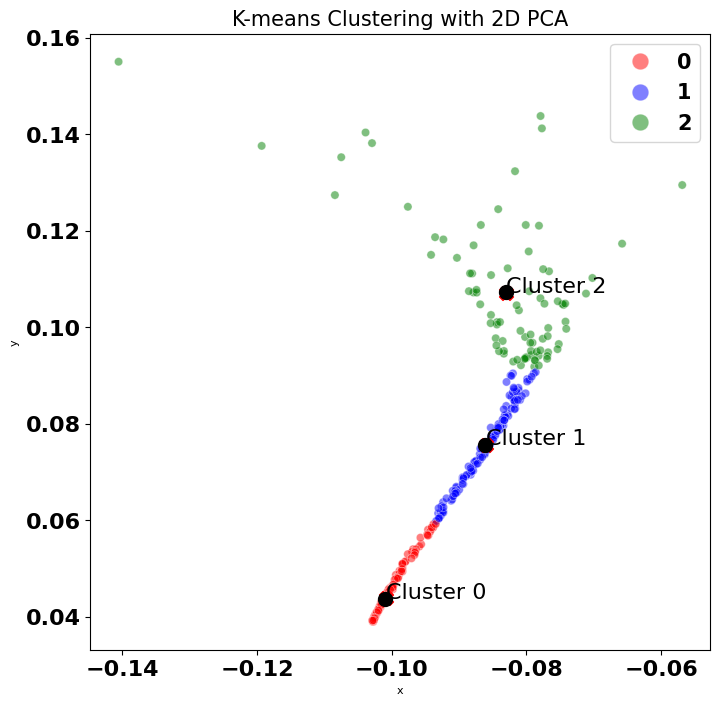

In [65]:
df = pd.DataFrame(data=encoded, columns=['x', 'y'])
df['Cluster'] = cluster_labels
for i in range(len(keys)):
    if(type(keys[i]) == tuple):
        df.at[i,'Label'] = f"abc{keys[i]}"
    else:
        df.at[i,'Label'] = keys[i]
        
closest = []
for center in centroids:
    distance = np.sqrt((df['x'] - center[0]) ** 2 + (df['y'] - center[1]) **2)
    min_dist_idx = np.argmin(distance)
    closest.append(df.iloc[min_dist_idx])

closest_points_df = pd.DataFrame(closest)
closest_points_df

# Plotting
plt.figure(figsize=(8,8))
sns.scatterplot(data=df, x='x', y='y', hue='Cluster', palette=['red', 'blue', 'green'], alpha=0.5)
for i, (cx, cy) in enumerate(centroids):
    plt.scatter(cx, cy, c='red', marker='X', s=100)
    plt.text(cx, cy, f'Cluster {i}', color='black', fontsize=16)
for i, row in closest_points_df.iterrows():
    plt.scatter(row['x'], row['y'], color='black', marker='o', s=100)

ref_points = df[df['Label'].str.startswith('ref')]
syn_points = df[df['Label'].str.startswith('abc')]
sns.scatterplot(data=ref_points, x='x', y='y', hue='Cluster', palette=['red', 'blue', 'green'], marker='D', edgecolor='gray', linewidth=0.5, alpha=0.7, legend=False)
plt.title('K-means Clustering with 2D PCA', fontsize = 15)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)
plt.xticks(fontsize=16, fontweight='bold')
plt.yticks(fontsize=16, fontweight='bold')

plt.xlabel('x', fontsize = 8)
plt.ylabel('y', fontsize = 8)
plt.legend(fontsize = 20, markerscale = 2, prop={'size' : 15,'weight': 'bold'})
ax = plt.gca()

In [ ]:
min_point = [-0.102783, 0.038921]

In [66]:
def calculate_projection_distance(row, central_point):
    point_vector = np.array([row['x'], row['y']]) - central_point
    projection_distance = np.sqrt(np.sum(point_vector**2))
    return projection_distance

In [67]:
df['projection_distance'] = df.apply(
    lambda row: calculate_projection_distance(row, min_point),
    axis=1
)

In [43]:
syn_df = df.tail(35)

In [74]:
syn_df

,x,y,Cluster,Label,projection_distance,c_a,c_b,bigger_value
343,-0.084139,0.079911,0,"abc(60, 60, 20)",0.045031,0.333333,0.333333,0.333333
344,-0.084565,0.097691,2,"abc(80, 80, 20)",0.061529,0.250000,0.250000,0.250000
345,-0.082965,0.088627,0,"abc(70, 70, 20)",0.053511,0.285714,0.285714,0.285714
346,-0.090370,0.065687,0,"abc(30, 70, 20)",0.029505,0.666667,0.285714,0.666667
347,-0.084261,0.079293,0,"abc(50, 70, 20)",0.044418,0.400000,0.285714,0.400000
348,-0.083342,0.095046,2,"abc(85, 70, 20)",0.059397,0.235294,0.285714,0.285714
349,-0.083534,0.097124,2,"abc(90, 70, 20)",0.061304,0.222222,0.285714,0.285714
350,-0.083930,0.101052,2,"abc(100, 70, 20)",0.064929,0.200000,0.285714,0.285714
351,-0.090886,0.064922,0,"abc(70, 30, 20)",0.028594,0.285714,0.666667,0.666667
352,-0.084180,0.079111,0,"abc(70, 50, 20)",0.044287,0.285714,0.400000,0.400000


In [69]:
syn_df['c_a'] = c_a
syn_df['c_b'] = c_b

C:\Users\rahuja7\AppData\Local\Temp\ipykernel_37080\2329619448.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syn_df['c_a'] = c_a
C:\Users\rahuja7\AppData\Local\Temp\ipykernel_37080\2329619448.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syn_df['c_b'] = c_b


In [70]:
syn_df['bigger_value'] = syn_df[['c_a', 'c_b']].max(axis=1)
syn_df

C:\Users\rahuja7\AppData\Local\Temp\ipykernel_37080\371055065.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syn_df['bigger_value'] = syn_df[['c_a', 'c_b']].max(axis=1)


,x,y,Cluster,Label,projection_distance,c_a,c_b,bigger_value
343,-0.084139,0.079911,0,"abc(60, 60, 20)",0.045031,0.333333,0.333333,0.333333
344,-0.084565,0.097691,2,"abc(80, 80, 20)",0.061529,0.250000,0.250000,0.250000
345,-0.082965,0.088627,0,"abc(70, 70, 20)",0.053511,0.285714,0.285714,0.285714
346,-0.090370,0.065687,0,"abc(30, 70, 20)",0.029505,0.666667,0.285714,0.666667
347,-0.084261,0.079293,0,"abc(50, 70, 20)",0.044418,0.400000,0.285714,0.400000
348,-0.083342,0.095046,2,"abc(85, 70, 20)",0.059397,0.235294,0.285714,0.285714
349,-0.083534,0.097124,2,"abc(90, 70, 20)",0.061304,0.222222,0.285714,0.285714
350,-0.083930,0.101052,2,"abc(100, 70, 20)",0.064929,0.200000,0.285714,0.285714
351,-0.090886,0.064922,0,"abc(70, 30, 20)",0.028594,0.285714,0.666667,0.666667
352,-0.084180,0.079111,0,"abc(70, 50, 20)",0.044287,0.285714,0.400000,0.400000


In [81]:
def get_prefix(value, prefixes):
    for prefix in prefixes:
        if value.startswith(prefix):
            return prefix
    return None

In [82]:
processes = ['unsm', 'pwjp', 'lsp']
df['process'] = df['Label'].apply(lambda x: get_prefix(x, processes))

In [85]:
df

,x,y,Cluster,Label,projection_distance,process
0,-0.102738,0.038993,1,lsp_10gw_01,0.000085,lsp
1,-0.093074,0.060267,2,lsp_10gw_02,0.023451,lsp
2,-0.098850,0.049484,1,lsp_10gw_03,0.011271,lsp
3,-0.079894,0.089221,2,lsp_10gw_04,0.055263,lsp
4,-0.094163,0.114979,0,lsp_10gw_05,0.076545,lsp
...,...,...,...,...,...,...
373,-0.087423,0.107723,0,"abc(100, 100, 25)",0.070496,None
374,-0.097603,0.124948,0,"abc(100, 100, 15)",0.086183,None
375,-0.102852,0.039160,1,"abc(3, 30, 15)",0.000249,None
376,-0.097066,0.052063,1,"abc(30, 30, 15)",0.014332,None


In [71]:
cluster_val = syn_points['Cluster']

In [83]:
df = df.head(343)
process = df['process']
df

,x,y,Cluster,Label,projection_distance,process
0,-0.102738,0.038993,0,lsp_10gw_01,0.000085,lsp
1,-0.093074,0.060267,1,lsp_10gw_02,0.023451,lsp
2,-0.098850,0.049484,0,lsp_10gw_03,0.011271,lsp
3,-0.079894,0.089221,1,lsp_10gw_04,0.055263,lsp
4,-0.094163,0.114979,2,lsp_10gw_05,0.076545,lsp
...,...,...,...,...,...,...
338,-0.102206,0.040869,0,unsm_8kg_38,0.002032,unsm
339,-0.080107,0.121175,2,unsm_8kg_39,0.085322,unsm
340,-0.071166,0.106952,2,unsm_8kg_40,0.075019,unsm
341,-0.140543,0.155021,2,unsm_8kg_41,0.122086,unsm


In [68]:
c_a = []
c_b = []
c_list = []
areas = []
for vals in abc_vals:
    a = vals[0]
    b = vals[1]
    c = vals[2]
    c_list.append(c)
    c_a.append(c/a)
    c_b.append(c/b)
    areas.append(np.pi * a * b * (0.64 / 224 **2))

In [102]:
correlation = syn_df['bigger_value'].corr(syn_df['projection_distance'], method='spearman')
print(correlation)

-0.9622409555148564


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


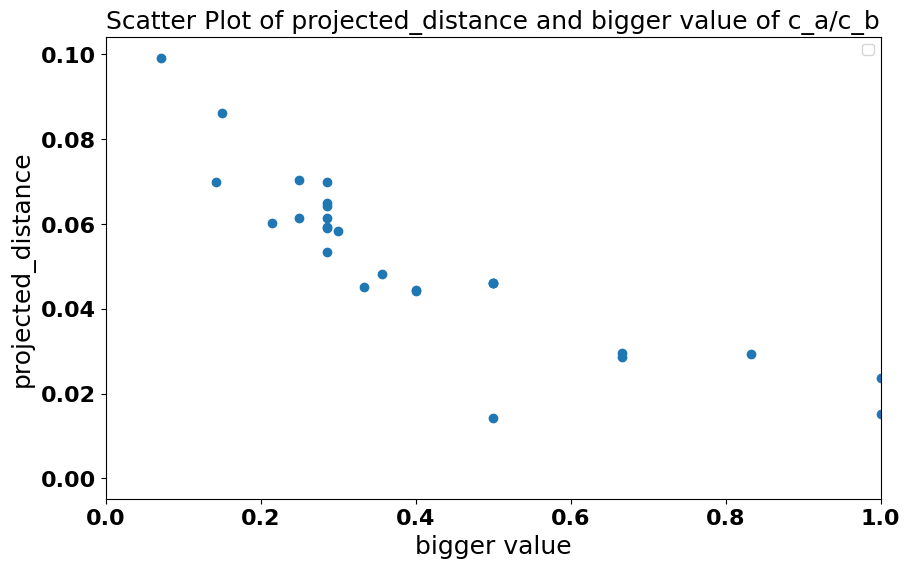

In [85]:
data = pd.DataFrame({
    'bigger_value' : syn_df['bigger_value'],
    'projected_dist' : syn_df['projection_distance']
})

plt.figure(figsize=(10, 6))
plt.scatter(data['bigger_value'], data['projected_dist'])
plt.xlim(0, 1)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)
plt.xticks(fontsize=16, fontweight='bold')
plt.yticks(fontsize=16, fontweight='bold')
plt.xlabel('bigger value', fontsize = 18)
plt.ylabel('projected_distance', fontsize = 18)
plt.title('Scatter Plot of projected_distance and bigger value of c_a/c_b', fontsize = 18)
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


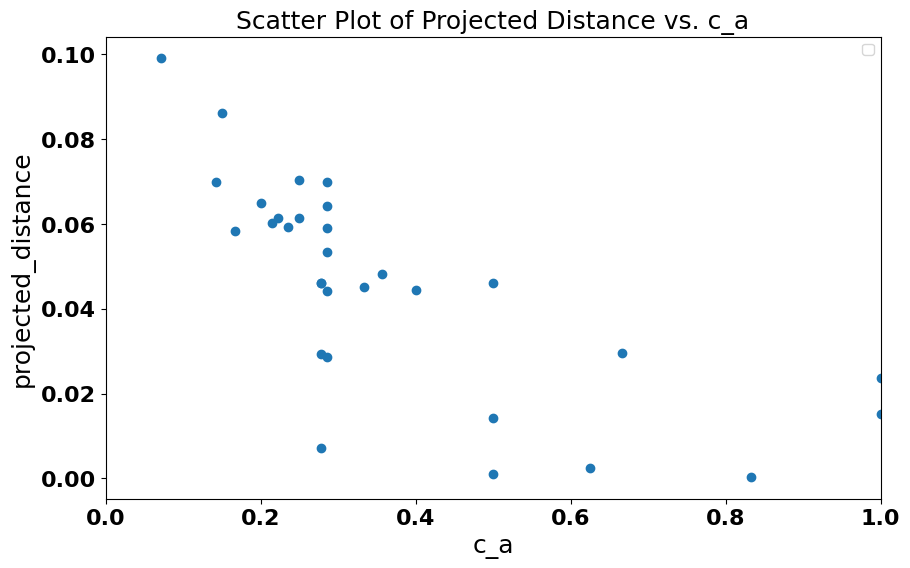

In [86]:
data = pd.DataFrame({
    'c_a' : c_a,
    'projected_dist' : syn_df['projection_distance']
})

plt.figure(figsize=(10, 6))
plt.scatter(data['c_a'], data['projected_dist'], )
plt.xlim(0, 1)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)
plt.xticks(fontsize=16, fontweight='bold')
plt.yticks(fontsize=16, fontweight='bold')
plt.xlabel('c_a', fontsize = 18)
plt.ylabel('projected_distance', fontsize = 18)
plt.title('Scatter Plot of Projected Distance vs. c_a', fontsize = 18)
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


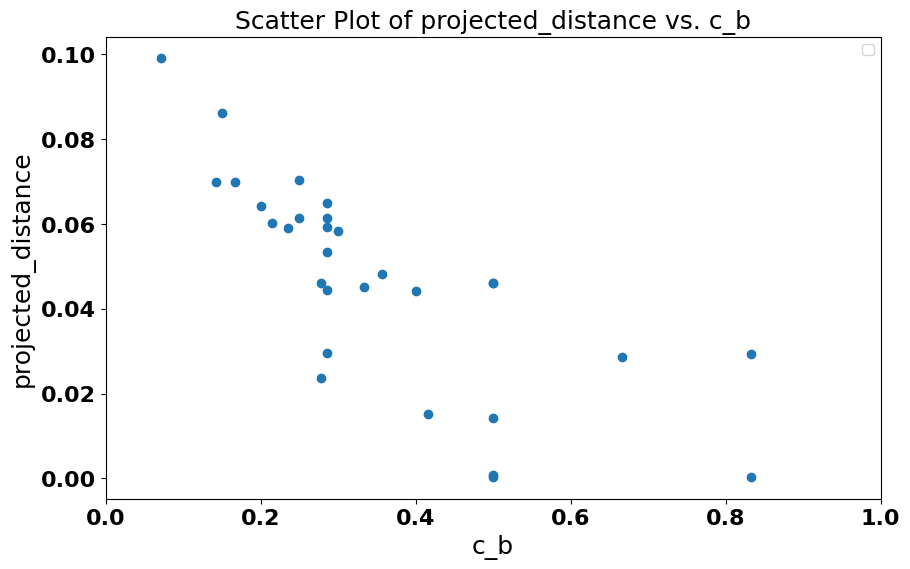

In [87]:
data = pd.DataFrame({
    'c_b' : c_b,
    'projected_dist' : syn_df['projection_distance']
})

plt.figure(figsize=(10, 6))
plt.scatter(data['c_b'], data['projected_dist'], )
plt.xlim(0, 1)
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)
plt.xticks(fontsize=16, fontweight='bold')
plt.yticks(fontsize=16, fontweight='bold')
plt.xlabel('c_b', fontsize = 18)
plt.ylabel('projected_distance', fontsize = 18)
plt.title('Scatter Plot of projected_distance vs. c_b', fontsize = 18)
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


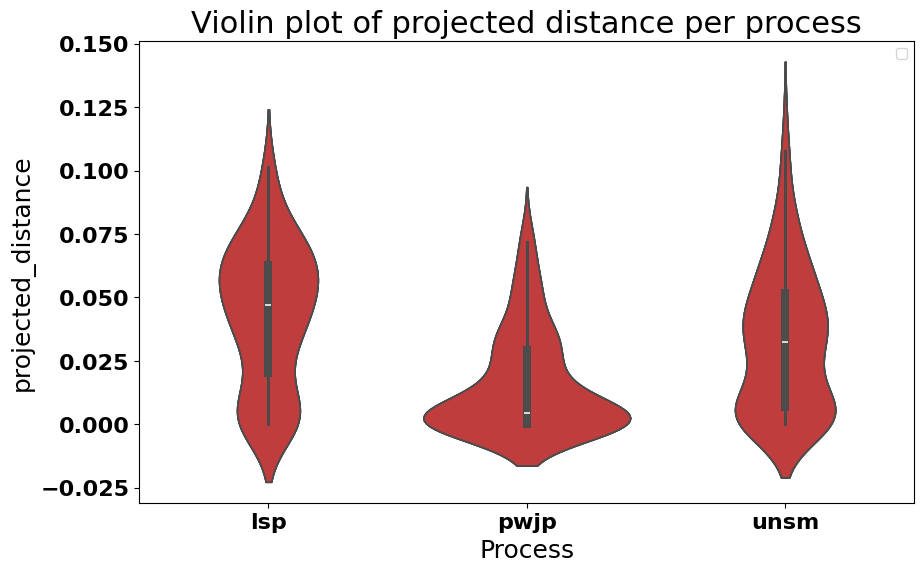

In [84]:
data = pd.DataFrame({
    'process' : process,
    'projected_dist' : df['projection_distance']
})

plt.figure(figsize=(10, 6))
for cluster in data['process'].unique():
    subset = data[data['process'] == cluster]
    sns.violinplot(x='process', y='projected_dist', data=data)

plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)
plt.xticks(fontsize=16, fontweight='bold')
plt.yticks(fontsize=16, fontweight='bold')
plt.xlabel('Process', fontsize = 18)
plt.ylabel('projected_distance', fontsize = 18)
plt.title('Violin plot of projected distance per process', fontsize = 22)
plt.legend()
plt.show()


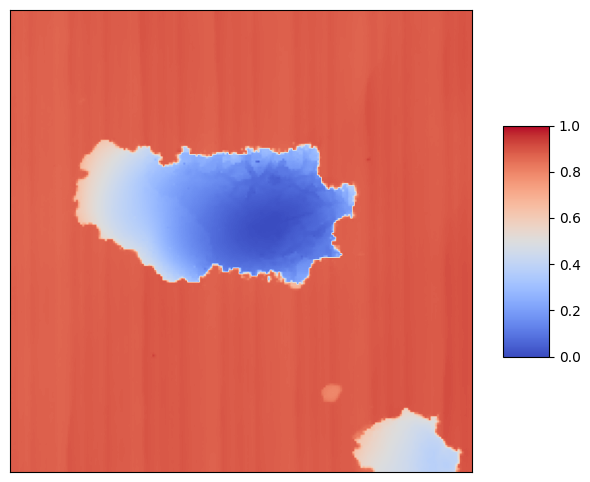

In [95]:
fig, ax = plt.subplots(figsize=(8, 6))
heatmap = ax.imshow(translated[200], cmap='coolwarm', extent=[0, 1000, 0, 1000], vmin = 0, vmax = 1)
plt.xticks(ticks=[], labels=[])
plt.yticks(ticks=[], labels=[])
fig.colorbar(heatmap, ax=ax, shrink=0.5, aspect=5)
plt.show()

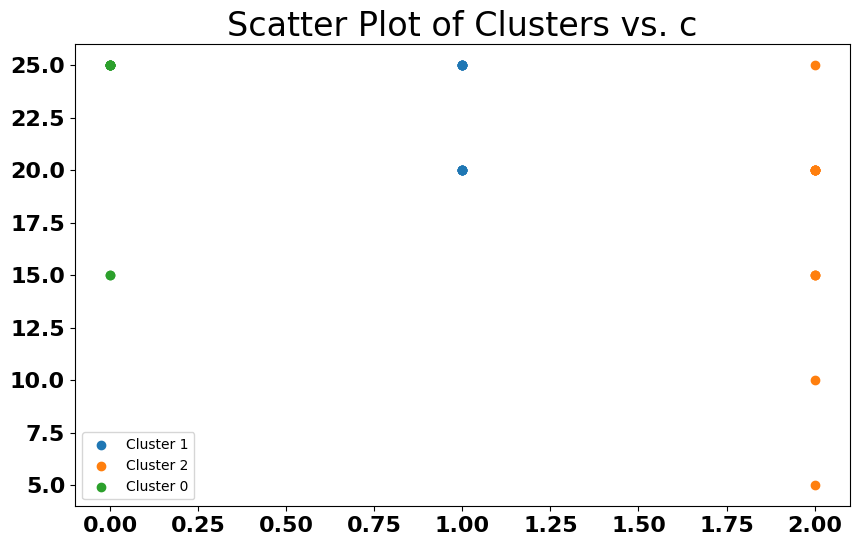

In [72]:
data = pd.DataFrame({
    'Cluster':cluster_val,
    'c': c_list
})

plt.figure(figsize=(10, 6))
for cluster in data['Cluster'].unique():
    subset = data[data['Cluster'] == cluster]
    plt.scatter(subset['Cluster'], subset['c'], label=f'Cluster {cluster}')

plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)
plt.xticks(fontsize=16, fontweight='bold')
plt.yticks(fontsize=16, fontweight='bold')
ax.set_xlabel('Cluster', fontsize = 20)
ax.set_ylabel('C value of ellipse', fontsize = 20)
plt.title('Scatter Plot of Clusters vs. c', fontsize = 24)
plt.legend()
plt.show()

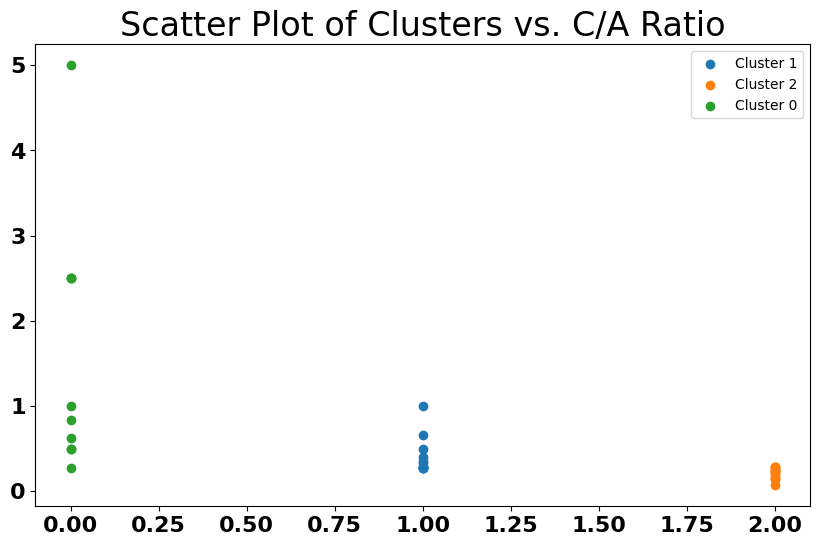

In [75]:
data = pd.DataFrame({
    'Cluster':cluster_val,
    'c/a_ratio': c_a
})

plt.figure(figsize=(10, 6))
for cluster in data['Cluster'].unique():
    subset = data[data['Cluster'] == cluster]
    plt.scatter(subset['Cluster'], subset['c/a_ratio'], label=f'Cluster {cluster}')

plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)
plt.xticks(fontsize=16, fontweight='bold')
plt.yticks(fontsize=16, fontweight='bold')
ax.set_xlabel('Cluster', fontsize = 20)
ax.set_ylabel('C/A Ratio', fontsize = 20)
plt.title('Scatter Plot of Clusters vs. C/A Ratio', fontsize = 24)
plt.legend()
plt.show()

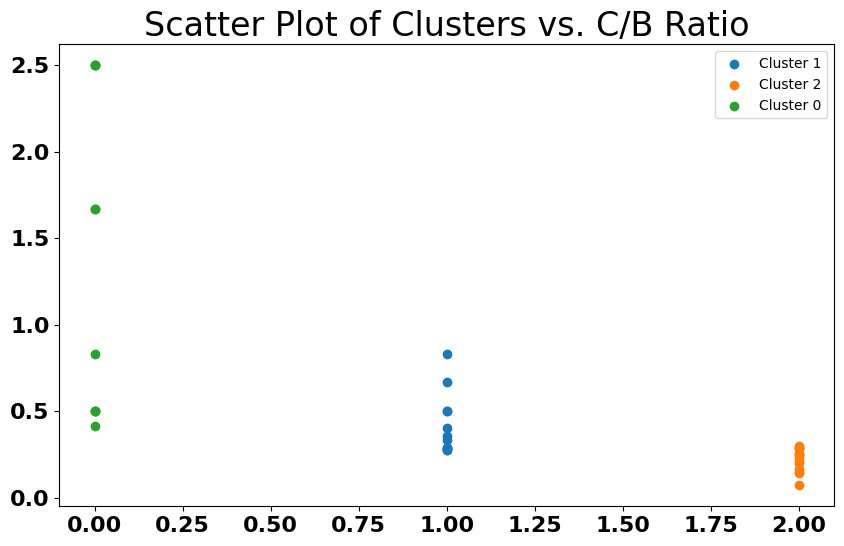

In [76]:
data = pd.DataFrame({
    'Cluster':cluster_val,
    'c/b_ratio': c_b
})

plt.figure(figsize=(10, 6))
for cluster in data['Cluster'].unique():
    subset = data[data['Cluster'] == cluster]
    plt.scatter(subset['Cluster'], subset['c/b_ratio'], label=f'Cluster {cluster}')


plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)
plt.xticks(fontsize=16, fontweight='bold')
plt.yticks(fontsize=16, fontweight='bold')
ax.set_xlabel('Cluster', fontsize = 20)
ax.set_ylabel('C/B Ratio', fontsize = 20)
plt.title('Scatter Plot of Clusters vs. C/B Ratio', fontsize = 24)
plt.legend()
plt.show()


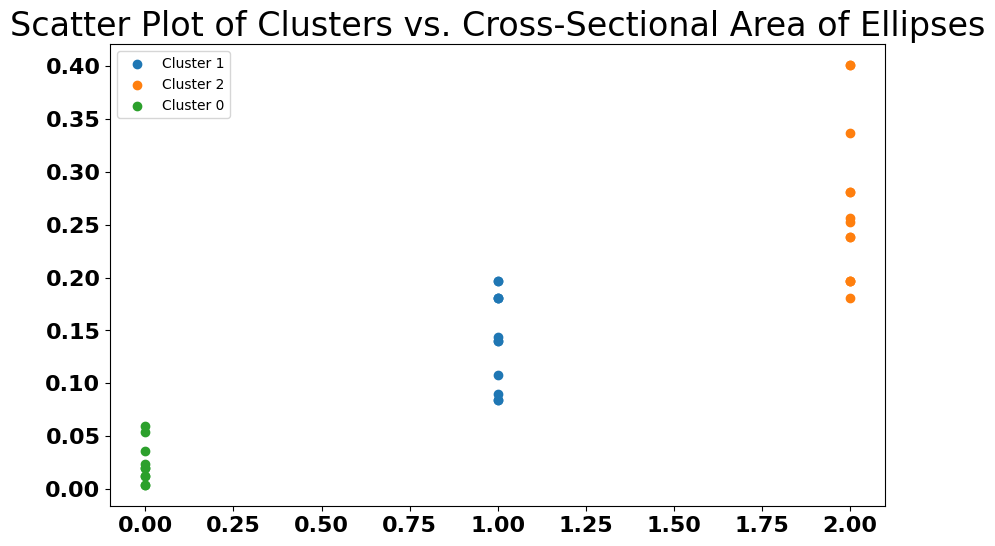

In [77]:
data = pd.DataFrame({
    'Cluster': cluster_val,
    'Area': areas
})

# Scatter plot
plt.figure(figsize=(10, 6))
for cluster in data['Cluster'].unique():
    subset = data[data['Cluster'] == cluster]
    plt.scatter(subset['Cluster'], subset['Area'], label=f'Cluster {cluster}')

plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)
plt.xticks(fontsize=16, fontweight='bold')
plt.yticks(fontsize=16, fontweight='bold')
ax.set_xlabel('Cluster', fontsize = 20)
ax.set_ylabel('Cross-Sectional Area', fontsize = 20)
plt.title('Scatter Plot of Clusters vs. Cross-Sectional Area of Ellipses', fontsize = 24)
plt.legend()
plt.show()


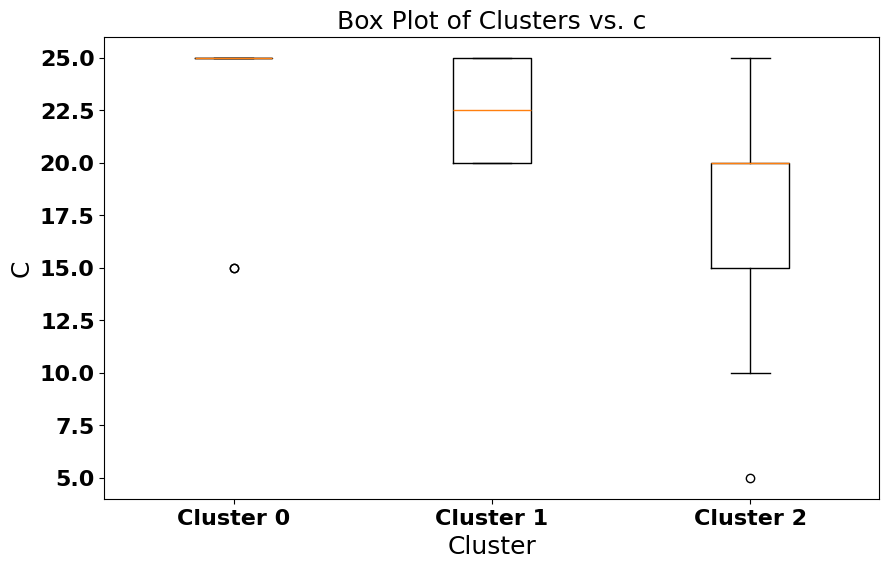

In [88]:
# Box plot
data = pd.DataFrame({
    'Cluster':cluster_val,
    'c': c_list
})
data = data.sort_values(by = 'Cluster')
plt.figure(figsize=(10, 6))
plt.boxplot([data[data['Cluster'] == cluster]['c'] for cluster in data['Cluster'].unique()],
            labels=[f'Cluster {cluster}' for cluster in data['Cluster'].unique()])

plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)
plt.xticks(fontsize=16, fontweight='bold')
plt.yticks(fontsize=16, fontweight='bold')
plt.xlabel('Cluster', fontsize = 18)
plt.ylabel('C', fontsize = 18)
plt.title('Box Plot of Clusters vs. c', fontsize = 18)
plt.show()


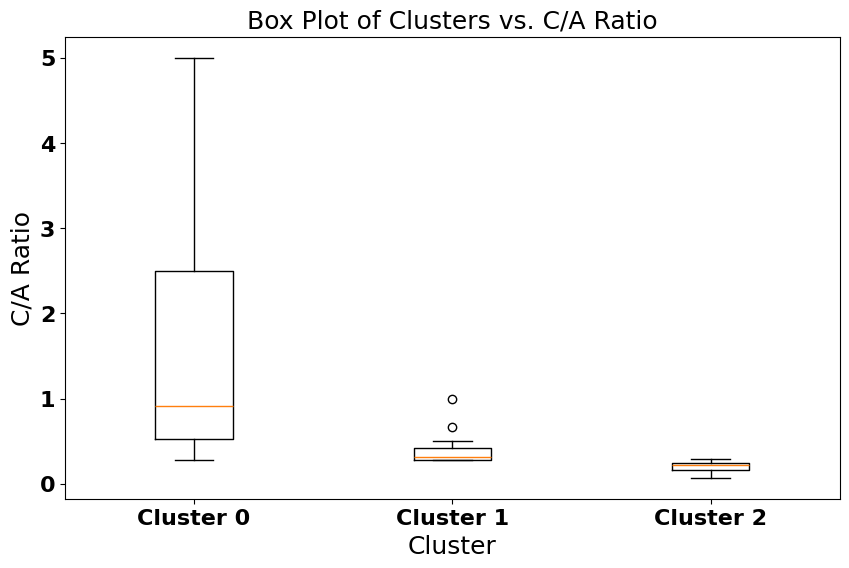

In [90]:
data = pd.DataFrame({
    'Cluster':cluster_val,
    'c/a_ratio': c_a
})
plt.figure(figsize=(10, 6))
data = data.sort_values(by = 'Cluster')
plt.boxplot([data[data['Cluster'] == cluster]['c/a_ratio'] for cluster in data['Cluster'].unique()],
            labels=[f'Cluster {cluster}' for cluster in data['Cluster'].unique()])

plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)
plt.xticks(fontsize=16, fontweight='bold')
plt.yticks(fontsize=16, fontweight='bold')
plt.xlabel('Cluster', fontsize = 18)
plt.ylabel('C/A Ratio', fontsize = 18)
plt.title('Box Plot of Clusters vs. C/A Ratio', fontsize = 18)
plt.show()

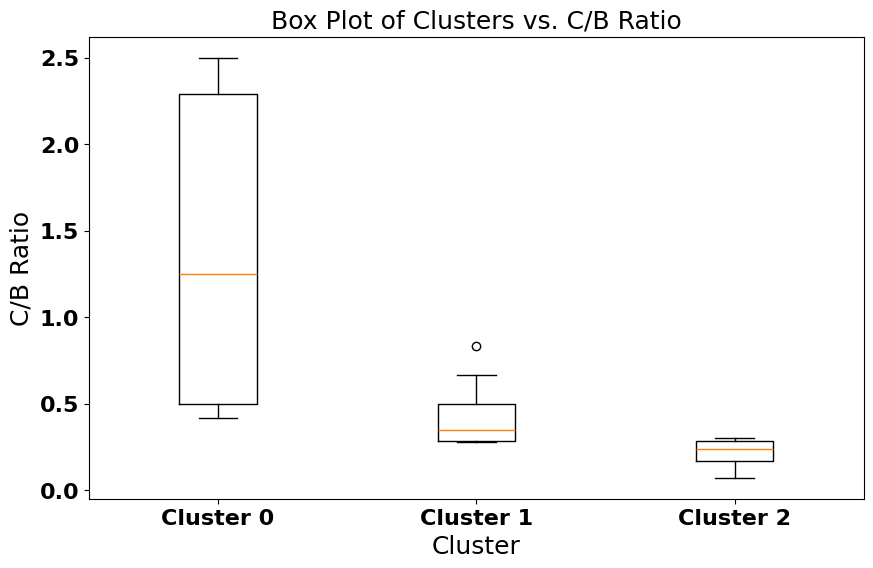

In [91]:
# Box plot
data = pd.DataFrame({
    'Cluster':cluster_val,
    'c/b_ratio': c_b
})
plt.figure(figsize=(10, 6))
data = data.sort_values(by = 'Cluster')
plt.boxplot([data[data['Cluster'] == cluster]['c/b_ratio'] for cluster in data['Cluster'].unique()],
            labels=[f'Cluster {cluster}' for cluster in data['Cluster'].unique()])

plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)
plt.xticks(fontsize=16, fontweight='bold')
plt.yticks(fontsize=16, fontweight='bold')
plt.xlabel('Cluster', fontsize = 18)
plt.ylabel('C/B Ratio', fontsize = 18)
plt.title('Box Plot of Clusters vs. C/B Ratio', fontsize = 18)
plt.show()


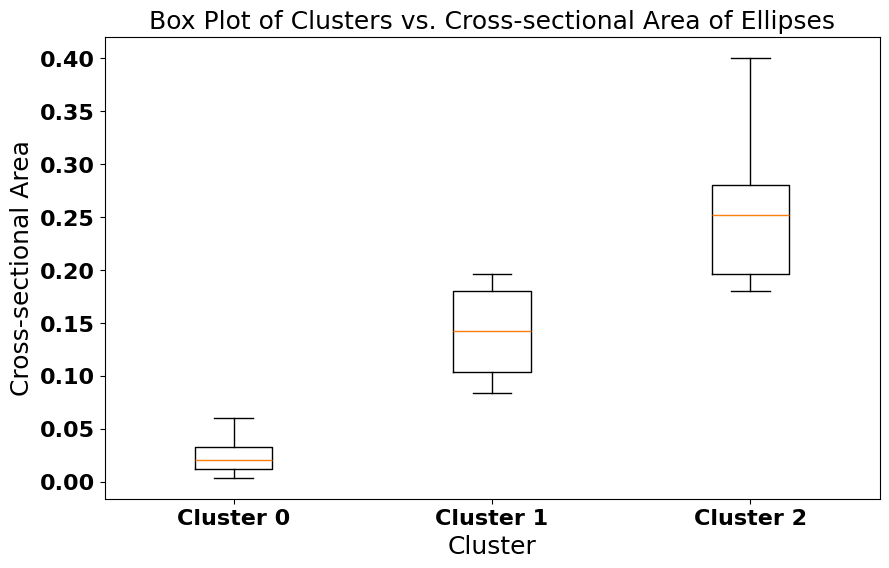

In [92]:
data = pd.DataFrame({
    'Cluster': cluster_val,
    'Area': areas 
})

# Box plot
plt.figure(figsize=(10, 6))
data = data.sort_values(by = 'Cluster')
plt.boxplot([data[data['Cluster'] == cluster]['Area'] for cluster in data['Cluster'].unique()], 
            labels=[f'Cluster {cluster}' for cluster in data['Cluster'].unique()])

plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)
plt.xticks(fontsize=16, fontweight='bold')
plt.yticks(fontsize=16, fontweight='bold')
plt.xlabel('Cluster', fontsize = 18)
plt.ylabel('Cross-sectional Area', fontsize = 18)
plt.title('Box Plot of Clusters vs. Cross-sectional Area of Ellipses', fontsize = 18)
plt.show()


C:\Users\rahuja7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\rahuja7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\rahuja7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.

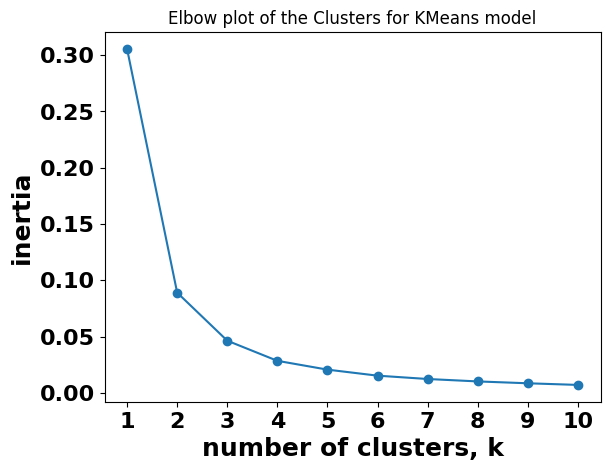

In [220]:
ks = range(1, 11)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(encoded)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k', fontsize = 18, fontweight = 'bold')
plt.ylabel('inertia', fontsize = 18, fontweight = 'bold')
plt.title('Elbow plot of the Clusters for KMeans model')
plt.xticks(fontsize=16, fontweight='bold')
plt.yticks(fontsize=16, fontweight='bold')
plt.xticks(ks)
plt.show()

In [105]:
lsp_0 = []
pwjp_0 = []
unsm_0 = []
ref_0 = []
lsp_1 = []
pwjp_1 = []
unsm_1 = []
ref_1 = []
lsp_2 = []
pwjp_2 = []
unsm_2 = []
ref_2 = []
others = []
for index, row in df.iterrows():
    if row['Cluster'] == 0:
        if row['Label'].startswith('lsp') or row['Label'].startswith('lps'):
            lsp_0.append(row['Label'])
        elif row['Label'].startswith('pwjp'):
            pwjp_0.append(row['Label'])
        elif row['Label'].startswith('unsm'):
            unsm_0.append(row['Label'])
        elif row['Label'].startswith('ref'):
            ref_0.append(row['Label'])
        else:
            others.append(row['Label'])
    elif row['Cluster'] == 1:
        if row['Label'].startswith('lsp') or row['Label'].startswith('lps'):
            lsp_1.append(row['Label'])
        elif row['Label'].startswith('pwjp'):
            pwjp_1.append(row['Label'])
        elif row['Label'].startswith('unsm'):
            unsm_1.append(row['Label'])
        elif row['Label'].startswith('ref'):
            ref_1.append(row['Label'])
        else:
            others.append(row['Label'])
    elif row['Cluster'] == 2:
        if row['Label'].startswith('lsp') or row['Label'].startswith('lps'):
            lsp_2.append(row['Label'])
        elif row['Label'].startswith('pwjp'):
            pwjp_2.append(row['Label'])
        elif row['Label'].startswith('unsm'):
            unsm_2.append(row['Label'])
        elif row['Label'].startswith('ref'):
            ref_2.append(row['Label'])
        else:
            others.append(row['Label'])
    else:
        others.append(row['Label'])

In [106]:
length_0 = {'lsp':len(lsp_0), 'pwjp':len(pwjp_0), 'unsm':len(unsm_0), 'ref':len(ref_0)}
length_1 = {'lsp':len(lsp_1), 'pwjp':len(pwjp_1), 'unsm':len(unsm_1), 'ref':len(ref_1)}
length_2 = {'lsp':len(lsp_2), 'pwjp':len(pwjp_2), 'unsm':len(unsm_2), 'ref':len(ref_2)}

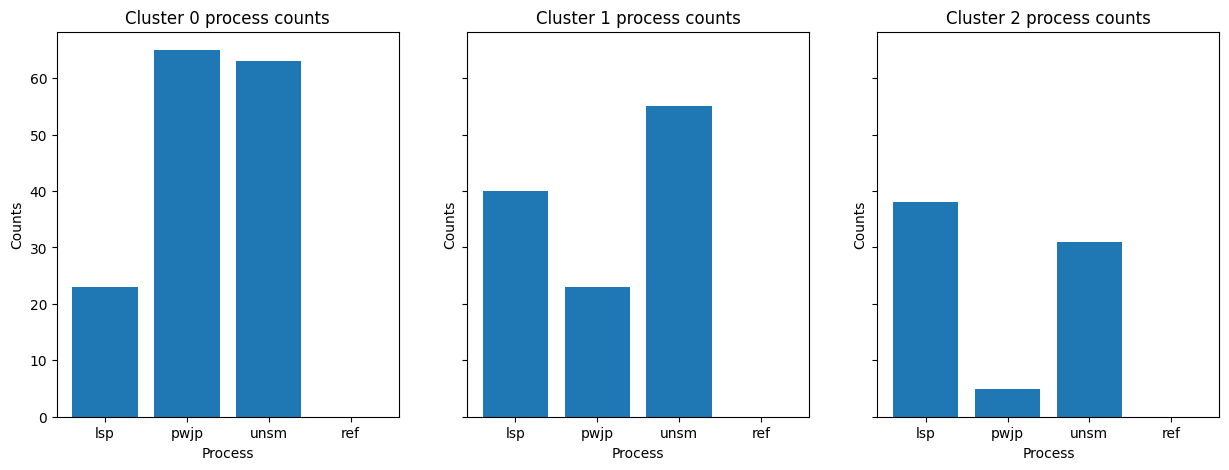

In [108]:
fig, axs = plt.subplots(1, 3, figsize = (15, 5), sharey = True)
axs[0].bar(length_0.keys(), length_0.values())
axs[0].set_title('Cluster 0 process counts')
axs[0].set_xlabel('Process')
axs[0].set_ylabel('Counts')
axs[1].bar(length_1.keys(), length_1.values())
axs[1].set_title('Cluster 1 process counts')
axs[1].set_xlabel('Process')
axs[1].set_ylabel('Counts')
axs[2].bar(length_2.keys(), length_2.values())
axs[2].set_title('Cluster 2 process counts')
axs[2].set_xlabel('Process')
axs[2].set_ylabel('Counts')
plt.show()

In [109]:
length_lsp = {'0':len(lsp_0), '1':len(lsp_1), '2':len(lsp_2)}
length_pwjp = {'0':len(pwjp_0), '1':len(pwjp_1), '2':len(pwjp_2)}
length_unsm = {'0':len(unsm_0), '1':len(unsm_1), '2':len(unsm_2)}
length_ref = {'0':len(ref_0), '1':len(ref_1), '2':len(ref_2)}

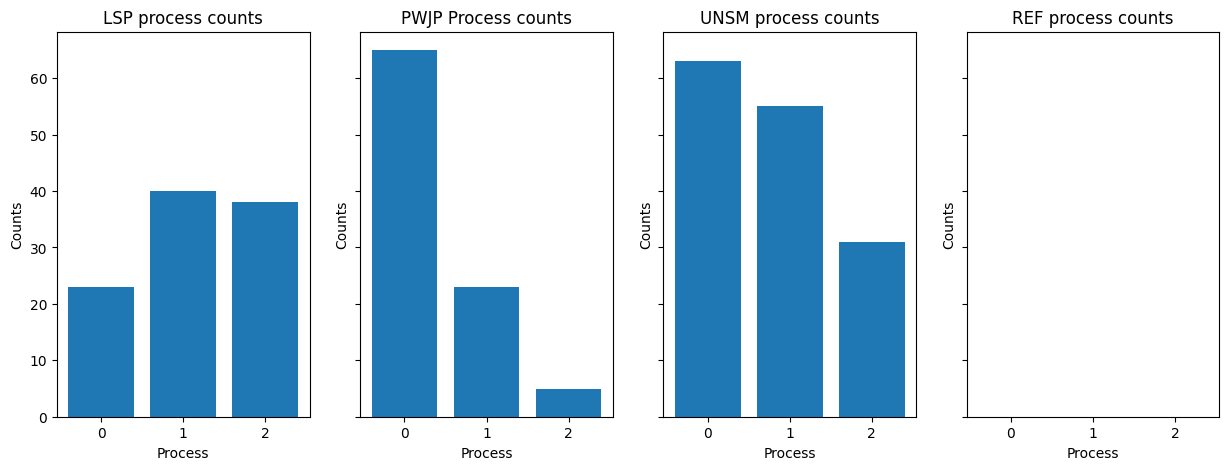

In [110]:
fig, axs = plt.subplots(1,4, figsize = (15, 5), sharey = True)
axs[0].bar(length_lsp.keys(), length_lsp.values())
axs[0].set_title('LSP process counts')
axs[0].set_xlabel('Process')
axs[0].set_ylabel('Counts')
axs[1].bar(length_pwjp.keys(), length_pwjp.values())
axs[1].set_title('PWJP Process counts')
axs[1].set_xlabel('Process')
axs[1].set_ylabel('Counts')
axs[2].bar(length_unsm.keys(), length_unsm.values())
axs[2].set_title('UNSM process counts')
axs[2].set_xlabel('Process')
axs[2].set_ylabel('Counts')
axs[3].bar(length_ref.keys(), length_ref.values())
axs[3].set_title('REF process counts')
axs[3].set_xlabel('Process')
axs[3].set_ylabel('Counts')
plt.show()

In [113]:
lsp_0 = []
pwjp_0 = []
unsm_0 = []
lsp_1 = []
pwjp_1 = []
unsm_1 = []
lsp_2 = []
pwjp_2 = []
unsm_2 = []
others = []
for index, row in df2.iterrows():
    if row['Cluster'] == 0:
        if row['Label'].startswith('lsp') or row['Label'].startswith('lps'):
            lsp_0.append(row['Label'])
        elif row['Label'].startswith('pwjp'):
            pwjp_0.append(row['Label'])
        elif row['Label'].startswith('unsm'):
            unsm_0.append(row['Label'])
        else:
            others.append(row['Label'])
    elif row['Cluster'] == 1:
        if row['Label'].startswith('lsp') or row['Label'].startswith('lps'):
            lsp_1.append(row['Label'])
        elif row['Label'].startswith('pwjp'):
            pwjp_1.append(row['Label'])
        elif row['Label'].startswith('unsm'):
            unsm_1.append(row['Label'])
        else:
            others.append(row['Label'])
    elif row['Cluster'] == 2:
        if row['Label'].startswith('lsp') or row['Label'].startswith('lps'):
            lsp_2.append(row['Label'])
        elif row['Label'].startswith('pwjp'):
            pwjp_2.append(row['Label'])
        elif row['Label'].startswith('unsm'):
            unsm_2.append(row['Label'])
        else:
            others.append(row['Label'])
    else:
        others.append(row['Label'])

In [114]:
length_0 = {'lsp':len(lsp_0), 'pwjp':len(pwjp_0), 'unsm':len(unsm_0)}
length_1 = {'lsp':len(lsp_1), 'pwjp':len(pwjp_1), 'unsm':len(unsm_1)}
length_2 = {'lsp':len(lsp_2), 'pwjp':len(pwjp_2), 'unsm':len(unsm_2)}

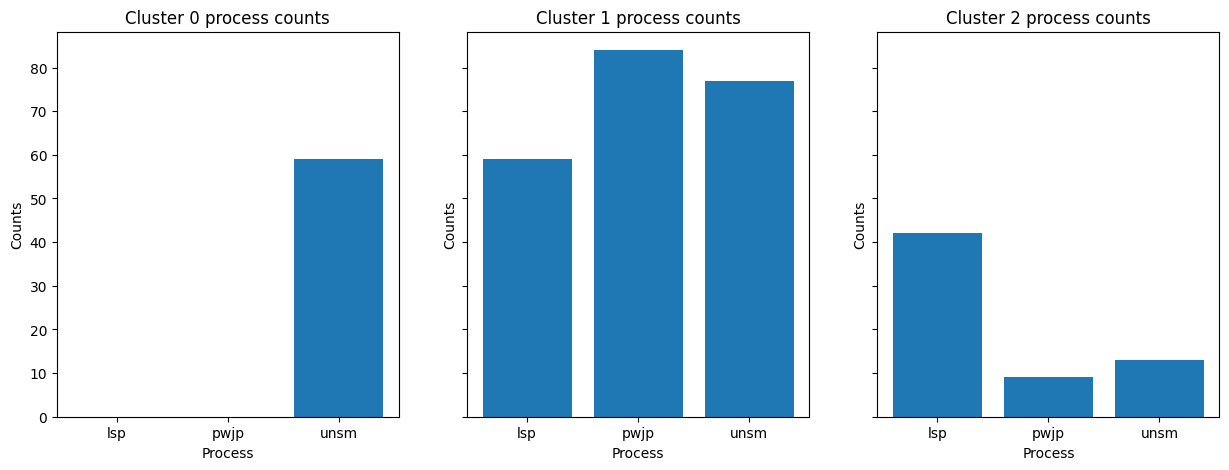

In [116]:
fig, axs = plt.subplots(1, 3, figsize = (15, 5), sharey = True)
axs[0].bar(length_0.keys(), length_0.values())
axs[0].set_title('Cluster 0 process counts')
axs[0].set_xlabel('Process')
axs[0].set_ylabel('Counts')
axs[1].bar(length_1.keys(), length_1.values())
axs[1].set_title('Cluster 1 process counts')
axs[1].set_xlabel('Process')
axs[1].set_ylabel('Counts')
axs[2].bar(length_2.keys(), length_2.values())
axs[2].set_title('Cluster 2 process counts')
axs[2].set_xlabel('Process')
axs[2].set_ylabel('Counts')
plt.show()

In [129]:
def change_typo(row):
    if row.startswith('lps'):
        return 'lsp' + row[3:]
    else:
        return row

In [130]:
df['Label'] = df['Label'].apply(change_typo)

C:\Users\rahuja7\AppData\Local\Temp\ipykernel_29876\3880935468.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(process_count.keys(), rotation = 90)
C:\Users\rahuja7\AppData\Local\Temp\ipykernel_29876\3880935468.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(process_count.keys(), rotation = 90)
C:\Users\rahuja7\AppData\Local\Temp\ipykernel_29876\3880935468.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(process_count.keys(), rotation = 90)


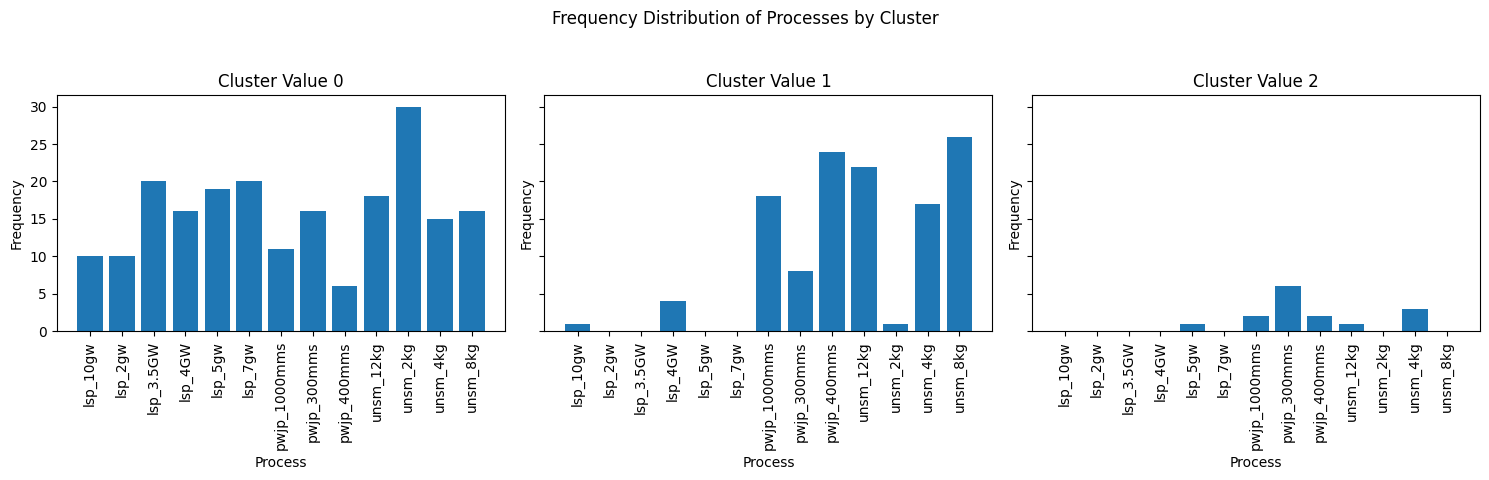

In [131]:
processes = ('lsp_10gw', 'lsp_2gw', 'lsp_3.5GW', 'lsp_4GW', 'lsp_5gw', 'lsp_7gw', 'pwjp_1000mms', 'pwjp_300mms', 'pwjp_400mms', 'unsm_12kg', 'unsm_2kg', 'unsm_4kg', 'unsm_8kg')

def count(data, processes):
    counts = {}
    for process in processes:
        count = data[data['Label'].str.startswith(process)].shape[0]
        counts[process] = count
    return counts

fig, axs = plt.subplots(1, 3, figsize = (15, 5), sharey = True)

for i, cluster in enumerate([0, 1, 2]):
    subset = df[df['Cluster'] == cluster]

    process_count = count(subset, processes)


    
    '''
    lsp = []
    pwjp = []
    unsm = []
    for index, row in subset.iterrows():
        if row['Label'].startswith('lsp') or row['Label'].startswith('lps'):
            lsp.append(row['Label'])
        elif row['Label'].startswith('pwjp'):
            pwjp.append(row['Label'])
        elif row['Label'].startswith('unsm'):
            unsm.append(row['Label'])
    length = {'lsp':len(lsp), 'pwjp':len(pwjp), 'unsm':len(unsm)}
    '''
    axs[i].bar(process_count.keys(), process_count.values())
    axs[i].set_title(f'Cluster Value {cluster}')
    axs[i].set_xlabel('Process')
    axs[i].set_ylabel('Frequency')
    axs[i].set_xticklabels(process_count.keys(), rotation = 90)

plt.suptitle('Frequency Distribution of Processes by Cluster')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()